In [ ]:
pip install --upgrade keras tensorflow

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import accuracy_score, jaccard_score, f1_score

In [10]:
import os
import glob
import json
import numpy as np
import cv2

from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D,Flatten,Dropout,BatchNormalization,Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint

In [11]:
train_path = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train'
test_path = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test'
valid_path = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid'

# Function to check if a path exists
def check_path(path):
    if os.path.exists(path):
        print(f"Path exists: {path}")
    else:
        print(f"Path does NOT exist: {path}")

# Check the paths
check_path(train_path)
check_path(test_path)
check_path(valid_path)

Path exists: /kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train
Path exists: /kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test
Path exists: /kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid


In [12]:
train_data=[image for image in os.listdir(train_path)]
test_data=[image for image in os.listdir(test_path)]
valid_data=[image for image in os.listdir(valid_path)]

In [13]:
# Check the number of images in each dataset
print(f"Number of training images: {len(train_data)}")
print(f"Number of test images: {len(test_data)}")
print(f"Number of validation images: {len(valid_data)}")

# Check the shape of some sample images to ensure consistency
sample_image_path = os.path.join(train_path, train_data[0])
sample_image = cv2.imread(sample_image_path)
print(f"Sample image shape: {sample_image.shape}")

Number of training images: 1503
Number of test images: 216
Number of validation images: 430
Sample image shape: (640, 640, 3)


In [14]:
train_annotation=glob.glob(os.path.join(train_path,"*.json"))
test_annotation=glob.glob(os.path.join(test_path,"*.json"))
valid_annotation=glob.glob(os.path.join(valid_path,"*.json"))

In [15]:
train_annotation=json.load(open(train_annotation[0]))
test_annotation=json.load(open(test_annotation[0]))
valid_annotation=json.load(open(valid_annotation[0]))

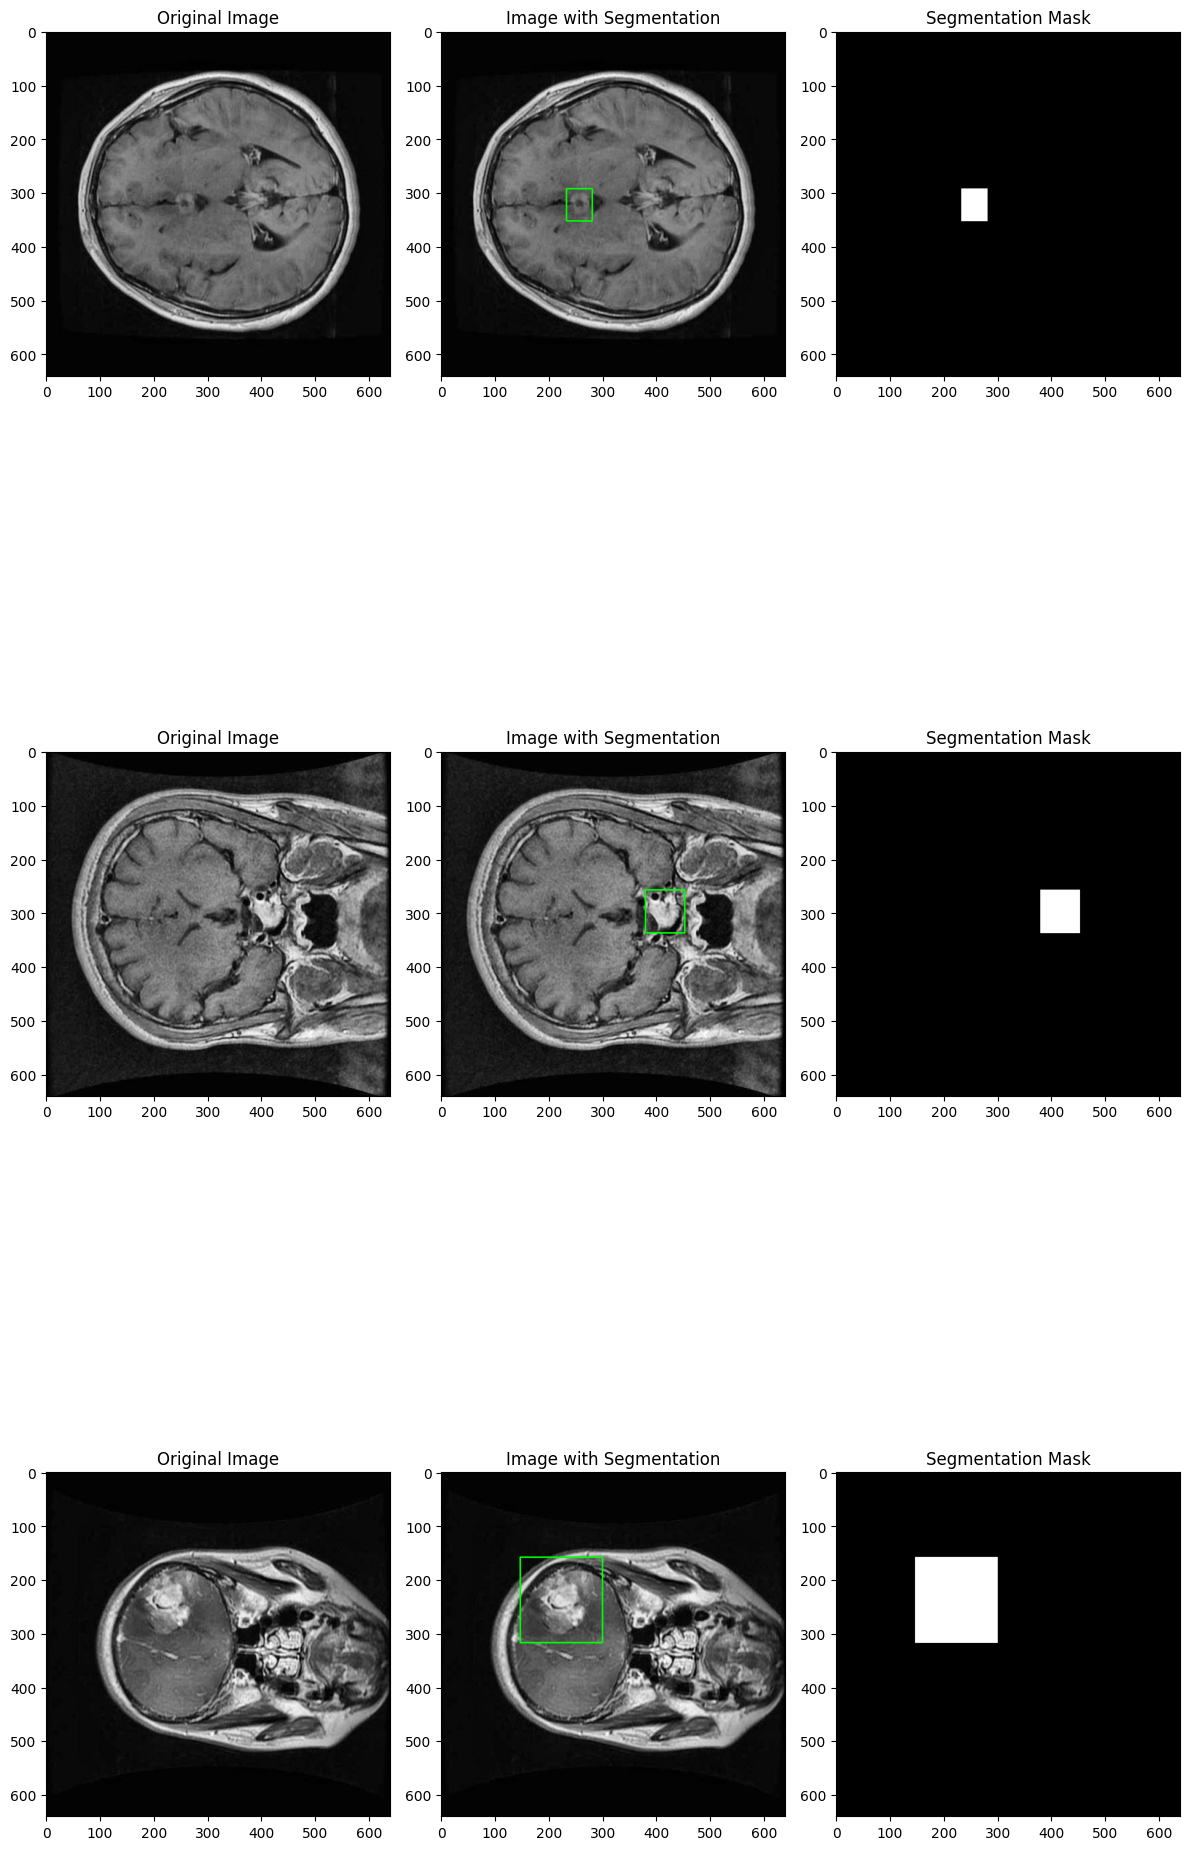

In [16]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

def visualize_random_images(n=3):
    # Select n random images
    indices = np.random.randint(0, len(train_annotation['images']), size=n)

    # Image and Annotation Retrieval:
    images = [train_annotation['images'][i] for i in indices]
    annotations = [train_annotation['annotations'][i] for i in indices]

    j = 1
    plt.figure(figsize=(12, 4 * 2 * n))

    for img, ann in zip(images, annotations):
        # Construct the full image path, assuming 'file_name' key contains the filename
        img_path = os.path.join(train_path, img['file_name'])

        # Load the image
        image = cv2.imread(img_path)

        # Check if the image was loaded properly
        if image is None:
            print(f"Error: Could not load image {img['file_name']}")
            continue

        # Convert image color to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Show original image
        plt.subplot(n, 3, j)
        plt.imshow(image)
        plt.title("Original Image")
        j += 1

        # Create masked images from annotations
        segmentation = ann['segmentation'][0]  # Assuming a single polygon for simplicity
        segmentation = np.array(segmentation, dtype=np.int32).reshape(-1, 2)  # Convert to 2D (Nx2)

        # Make a copy of the image to draw on
        img_with_segmentation = image.copy()

        # Draw the segmentation boundary on the image
        cv2.polylines(img_with_segmentation, [segmentation], isClosed=True, color=(0, 255, 0), thickness=2)  # Green color with thickness 2

        # Show the image with segmentation boundary
        plt.subplot(n, 3, j)
        plt.imshow(img_with_segmentation)
        plt.title("Image with Segmentation")
        j += 1

        # Create a mask using the segmentation
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=1)

        # Show the mask
        plt.subplot(n, 3, j)
        plt.imshow(mask, cmap='gray')
        plt.title("Segmentation Mask")
        j += 1

    # Display all images
    plt.tight_layout()
    plt.show()

visualize_random_images()

In [17]:
# Print segmentation data for debugging
def inspect_segmentation(annotation):
    print("Segmentation data:", annotation['segmentation'])

# Inspect the segmentation for a sample annotation
inspect_segmentation(train_annotation['annotations'][0])

Segmentation data: [[313.75, 238.75, 145, 238.75, 145, 401.25, 313.75, 401.25, 313.75, 238.75]]


In [18]:
# Define the preprocess_image_and_mask function
def preprocess_image_and_mask(image_path, annotation, target_size=(256, 256)):
    # Read and resize the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2]
    image = cv2.resize(image, target_size)

    # Create an empty mask
    mask = np.zeros(target_size, dtype=np.uint8)

    # Handle multiple segmentation polygons (if any)
    for seg in annotation['segmentation']:
        segmentation = np.array(seg, dtype=np.float32).reshape(-1, 2)  # Convert to 2D array

        # Scale the segmentation coordinates according to the original image size
        scale_x = target_size[1] / original_size[1]  # Scaling based on width
        scale_y = target_size[0] / original_size[0]  # Scaling based on height
        segmentation[:, 0] *= scale_x  # Scale x-coordinates
        segmentation[:, 1] *= scale_y  # Scale y-coordinates

        # Fill the mask with the scaled segmentation
        cv2.fillPoly(mask, [segmentation.astype(np.int32)], color=1)

    return image, mask

# Print image and mask dimensions for verification
def check_dimensions(image, mask):
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")

# Test on the first image and mask
sample_image, sample_mask = preprocess_image_and_mask(
    os.path.join(train_path, train_annotation['images'][0]['file_name']),
    train_annotation['annotations'][0]
)
check_dimensions(sample_image, sample_mask)

Image shape: (256, 256, 3)
Mask shape: (256, 256)


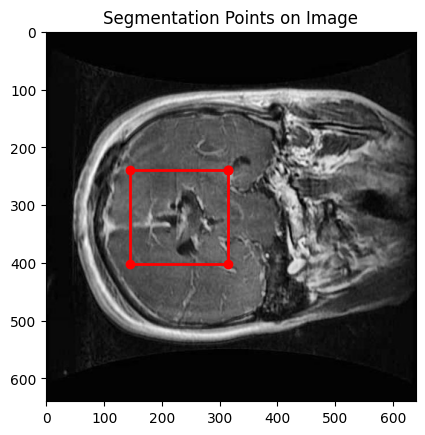

In [19]:
def visualize_segmentation_on_image(image_path, annotation):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.imshow(image)

    # Overlay segmentation points
    for seg in annotation['segmentation']:
        segmentation = np.array(seg, dtype=np.float32).reshape(-1, 2)
        plt.plot(segmentation[:, 0], segmentation[:, 1], 'ro-', linewidth=2)

    plt.title("Segmentation Points on Image")
    plt.show()

# Visualize the segmentation on a sample image
visualize_segmentation_on_image(
    os.path.join(train_path, train_annotation['images'][0]['file_name']),
    train_annotation['annotations'][0]
)

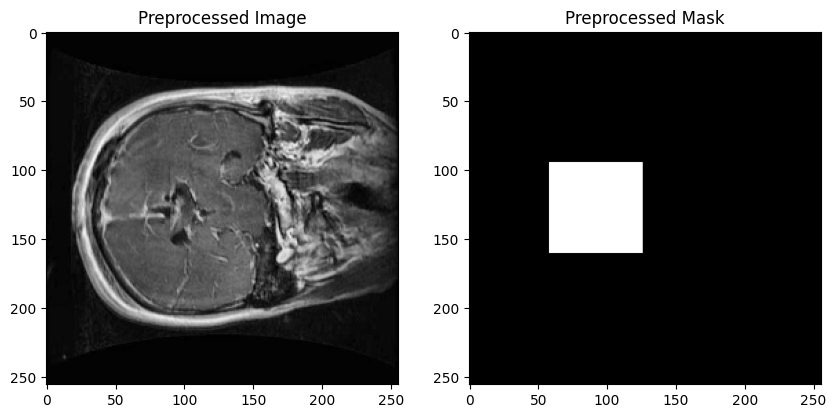

In [20]:
# Updated function to preprocess images and masks
def preprocess_image_and_mask(image_path, annotation, target_size=(256, 256)):
    # Read and resize the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2]
    image = cv2.resize(image, target_size)

    # Create an empty mask
    mask = np.zeros(target_size, dtype=np.uint8)

    # Handle multiple segmentation polygons (if any)
    for seg in annotation['segmentation']:
        segmentation = np.array(seg, dtype=np.float32).reshape(-1, 2)  # Convert to 2D array

        # Scale the segmentation coordinates according to the original image size
        scale_x = target_size[1] / original_size[1]  # Scaling based on width
        scale_y = target_size[0] / original_size[0]  # Scaling based on height
        segmentation[:, 0] *= scale_x  # Scale x-coordinates
        segmentation[:, 1] *= scale_y  # Scale y-coordinates

        # Fill the mask with the scaled segmentation
        cv2.fillPoly(mask, [segmentation.astype(np.int32)], color=1)

    return image, mask

# Test the updated preprocessing function
sample_image, sample_mask = preprocess_image_and_mask(
    os.path.join(train_path, train_annotation['images'][0]['file_name']),
    train_annotation['annotations'][0]
)

# Display preprocessed image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title("Preprocessed Image")

plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap='gray')
plt.title("Preprocessed Mask")
plt.show()

In [21]:
# Function to preprocess the entire dataset
def preprocess_dataset(images, annotations, path, target_size=(256, 256)):
    preprocessed_images = []
    preprocessed_masks = []

    for i in range(len(images)):
        image_path = os.path.join(path, images[i]['file_name'])
        image, mask = preprocess_image_and_mask(image_path, annotations[i], target_size)
        preprocessed_images.append(image)
        preprocessed_masks.append(mask)

    # Convert lists to numpy arrays for model input
    preprocessed_images = np.array(preprocessed_images)
    preprocessed_masks = np.array(preprocessed_masks)

    # Normalize images (values between 0 and 1)
    preprocessed_images = preprocessed_images / 255.0

    # Reshape masks for binary classification (adding a channel dimension)
    preprocessed_masks = np.expand_dims(preprocessed_masks, axis=-1)

    return preprocessed_images, preprocessed_masks

# Preprocess training set
X_train, y_train = preprocess_dataset(
    train_annotation['images'],
    train_annotation['annotations'],
    train_path
)

# Preprocess validation set (assuming valid_annotation and valid_path are defined)
X_valid, y_valid = preprocess_dataset(
    valid_annotation['images'],
    valid_annotation['annotations'],
    valid_path
)

# Preprocess test set (assuming test_annotation and test_path are defined)
X_test, y_test = preprocess_dataset(
    test_annotation['images'],
    test_annotation['annotations'],
    test_path
)

# Print the shapes of the preprocessed datasets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_valid.shape}, {y_valid.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (1502, 256, 256, 3), (1502, 256, 256, 1)
Validation set: (429, 256, 256, 3), (429, 256, 256, 1)
Test set: (215, 256, 256, 3), (215, 256, 256, 1)


In [22]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import jaccard_score, f1_score
import matplotlib.pyplot as plt

In [25]:
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import get_custom_objects

# Dice coefficient for binary segmentation
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.cast(y_true, 'float32')  # Convert y_true to float32
    y_pred_f = tf.keras.backend.flatten(y_pred)
    y_true_f = tf.keras.backend.flatten(y_true_f)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Dice loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Custom loss: binary crossentropy combined with dice loss
def combined_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Register the custom functions
get_custom_objects().update({
    'combined_loss': combined_loss,
    'dice_coefficient': dice_coefficient
})

In [26]:
model_unet = tf.keras.models.load_model('/kaggle/input/attenunet/keras/default/1/unet_brain_tumor_segmentation.keras')
model_attenunet = tf.keras.models.load_model('/kaggle/input/attenunet/keras/default/1/atttenunet_brain_tumor_segmentation.keras')

In [27]:

# Function to calculate model performance
def evaluate_model(model, X_test, y_test):
    """Evaluate the model on test set and return performance metrics."""
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_bin = np.round(y_pred)  # Binarize predictions (0 or 1)

    # Calculate metrics
    accuracy = np.mean(y_pred_bin == y_test)
    dice = dice_coefficient(y_test, y_pred_bin)
    
    # Flatten for calculating Jaccard and F1 metrics
    y_test_flat = y_test.flatten()
    y_pred_bin_flat = y_pred_bin.flatten()

    iou = jaccard_score(y_test_flat, y_pred_bin_flat, average='binary')
    f1 = f1_score(y_test_flat, y_pred_bin_flat)
    
    return accuracy, dice, iou, f1

In [28]:
# Evaluate UNet and AttenUNet
unet_results = evaluate_model(model_unet, X_test, y_test)
attenunet_results = evaluate_model(model_attenunet, X_test, y_test)

I0000 00:00:1728159744.078364     253 service.cc:146] XLA service 0x7fcd0410fab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728159744.078401     253 service.cc:154]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step

I0000 00:00:1728159767.059975     253 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step

E0000 00:00:1728159772.091621     255 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728159772.330621     255 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728159773.453530     255 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728159773.716880     255 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 578ms/step


In [29]:
# Display the results
print(f"UNet - Accuracy: {unet_results[0]:.4f}, Dice Coefficient: {unet_results[1]:.4f}, Jaccard Index: {unet_results[2]:.4f}, F1 Score: {unet_results[3]:.4f}")
print(f"AttenUNet - Accuracy: {attenunet_results[0]:.4f}, Dice Coefficient: {attenunet_results[1]:.4f}, Jaccard Index: {attenunet_results[2]:.4f}, F1 Score: {attenunet_results[3]:.4f}")

UNet - Accuracy: 0.9763, Dice Coefficient: 0.6598, Jaccard Index: 0.4923, F1 Score: 0.6598
AttenUNet - Accuracy: 0.9772, Dice Coefficient: 0.6848, Jaccard Index: 0.5207, F1 Score: 0.6848


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


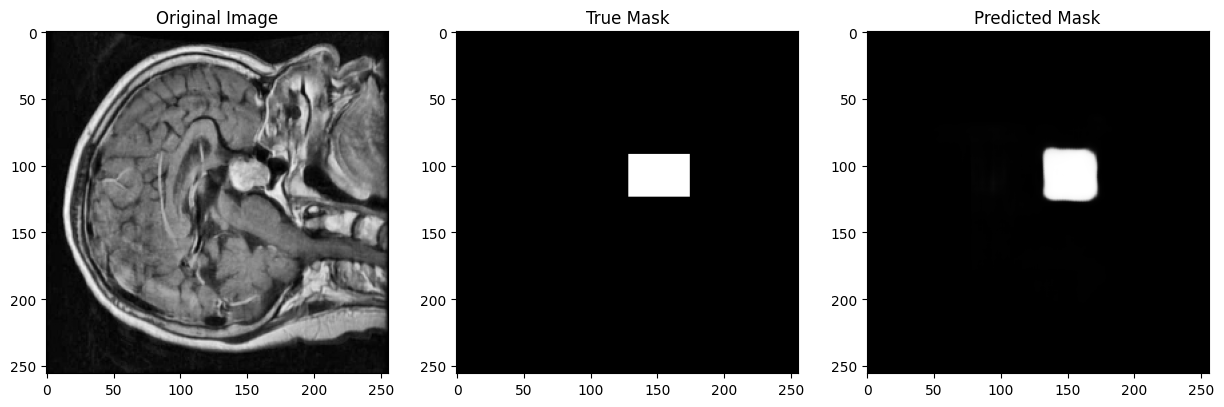

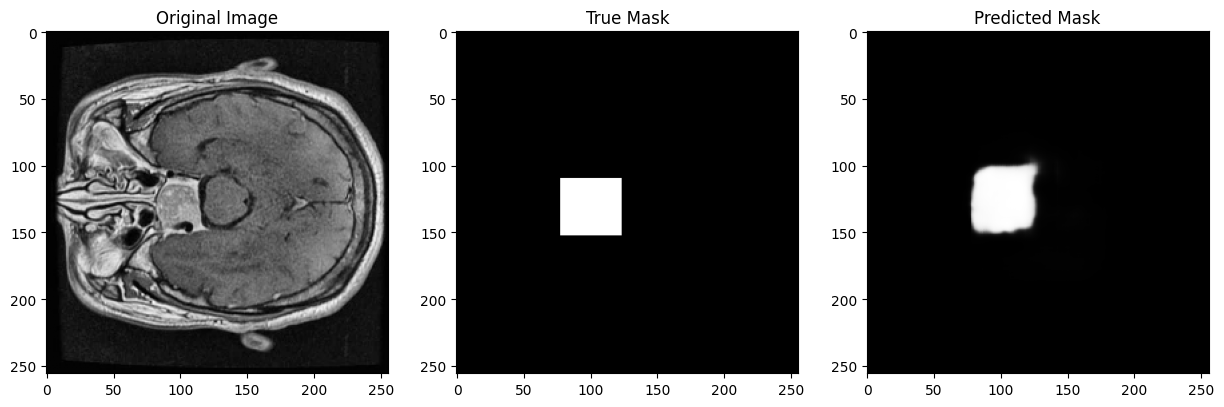

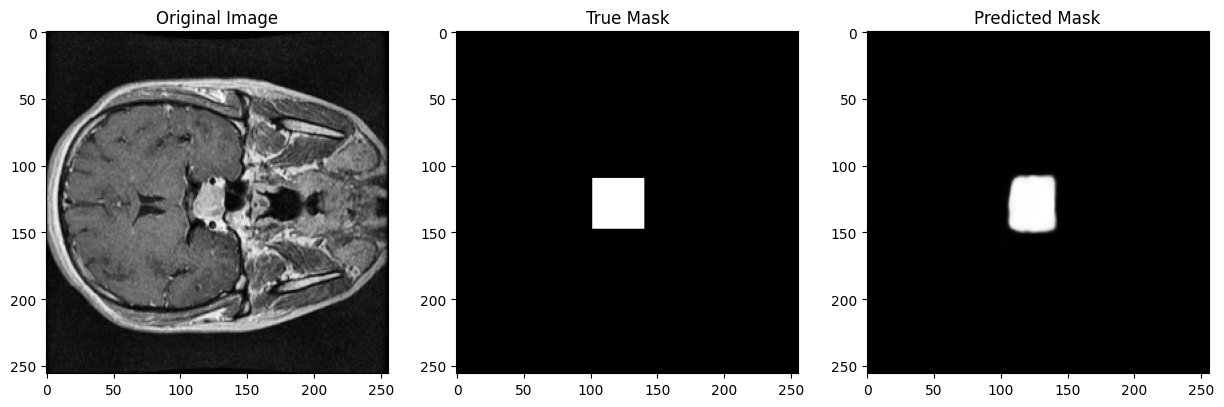

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step


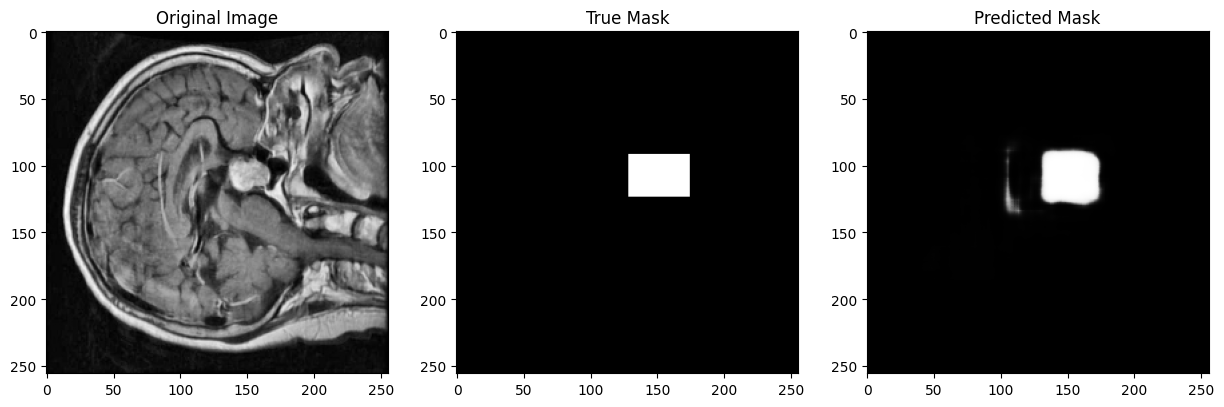

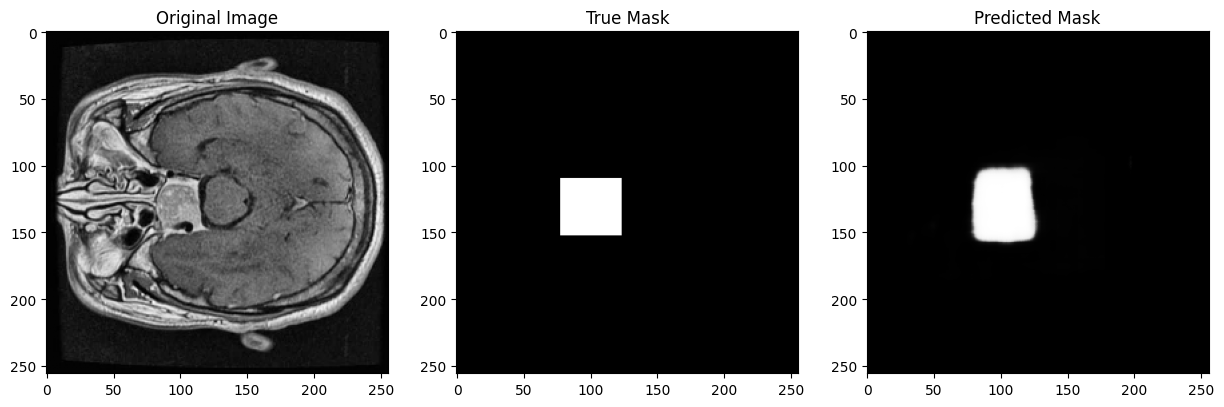

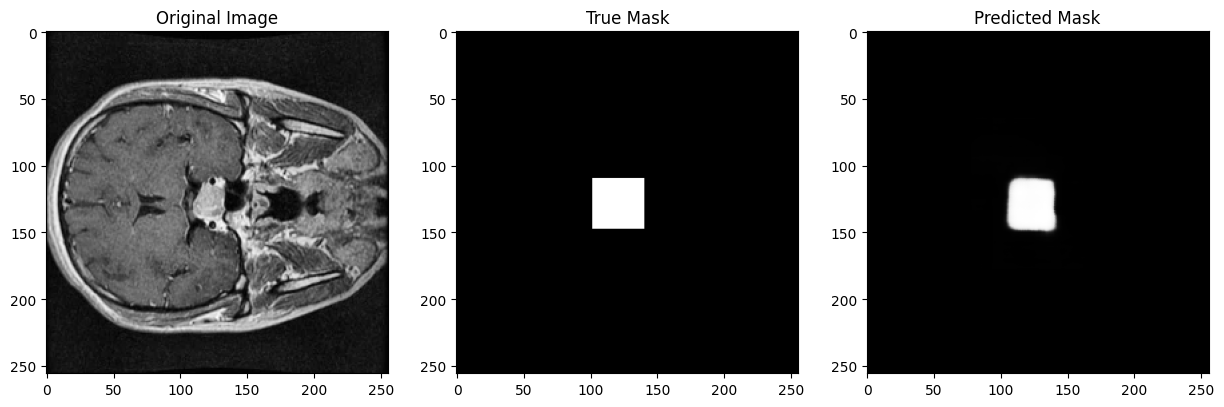

In [30]:
# Function to visualize the results
def visualize_results(X_test, y_test, y_pred, num_samples=3):
    """Visualize test images, ground truth masks, and predicted masks."""
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i])
        plt.title("Original Image")
        
        # Ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(y_test[i, :, :, 0], cmap='gray')
        plt.title("True Mask")
        
        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(y_pred[i, :, :, 0], cmap='gray')
        plt.title("Predicted Mask")
        
        plt.show()

# Predict and visualize results for UNet
y_pred_unet = model_unet.predict(X_test)
visualize_results(X_test, y_test, y_pred_unet, num_samples=3)

# Predict and visualize results for AttenUNet
y_pred_attenunet = model_attenunet.predict(X_test)
visualize_results(X_test, y_test, y_pred_attenunet, num_samples=3)

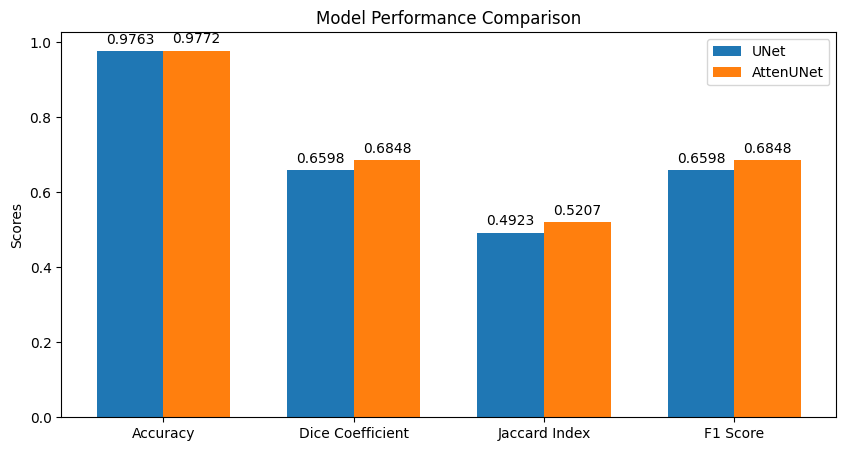

In [31]:
# Plotting performance comparison
labels = ['Accuracy', 'Dice Coefficient', 'Jaccard Index', 'F1 Score']
unet_scores = unet_results
attenunet_scores = attenunet_results

x = np.arange(len(labels))  # Label locations
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, unet_scores, width, label='UNet')
bars2 = ax.bar(x + width/2, attenunet_scores, width, label='AttenUNet')

# Add labels and title
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show values on top of the bars
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

add_values(bars1)
add_values(bars2)

plt.show()